### Summary

In this notebook, we'll compare the compute performance of the `TorchDiffEq` and `DiffEqPy` solver backends. This will also highlight some differences in how the dynamics and event functions should be implemented for each backend.

In [1]:
from chirho_diffeqpy import DiffEqPy, ATempParams
from chirho.dynamical.handlers.solver import TorchDiffEq
from chirho.dynamical.ops import simulate
from chirho.dynamical.handlers.trajectory import LogTrajectory
from chirho.dynamical.handlers import StaticBatchObservation, StaticIntervention, DynamicIntervention
from chirho.counterfactual.handlers import MultiWorldCounterfactual
from chirho.observational.handlers import condition
from chirho.dynamical.ops import State
import numpy as np
import torch
from pyro import sample, set_rng_seed
from pyro.distributions import Uniform, Poisson
from typing import Tuple, Optional, Union
from functools import partial
import matplotlib.pyplot as plt
import pyro
from pyro.infer.autoguide import AutoDelta, AutoMultivariateNormal
from contextlib import nullcontext
pyro.settings.set(module_local_params=True)

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


  Activating project at `~/.julia/environments/diffeqpy`
  Activating project at `~/.julia/environments/diffeqpy`
  Activating project at `~/.julia/environments/diffeqpy`


In [2]:
# DiffEqPy requires float64 values, so set the torch default dtype accordingly.
torch.set_default_dtype(torch.float64)

In [3]:
# The DiffEqPy backend interfaces with julia, so we must load a julia<>python interop backend.
import chirho_diffeqpy.lang_interop.julianumpy

  Activating project at `~/.julia/environments/diffeqpy`


In [4]:
# Define the dynamics "purely", meaning that the dynamics can reference only the state and atemporal parameter arguments thare are passed into it.
# We'll use a Lotka-Volterra system with one predator species, one prey species, and four parameters regulating the growth, predation, 
#  and death rates. For simplicity, we assume 10% efficiency in the conversion of prey to predator.

# Importantly, to use these dynamics for both torchdiffeq and diffeqpy, its implementation must support both numpy and torch arrays/tensors.
# The same requirement will apply to event functions, but otherwise, the DiffEqPy backend inputs and outputs are torch tensors.
# The reason is that julia code will be calling the dynamics and event functions with julia arrays, and the julianumpy backend that
#  we imported above will convert these arrays to numpy arrays, which will be passed to the dynamics and event functions for both execution
#  and jit compilation.
ArrayLike = Union[np.ndarray, torch.Tensor]

def pure_dynamics(state: State[ArrayLike], atemp_params: ATempParams[ArrayLike]) -> State[ArrayLike]:
    prey = state["prey"]
    predator = state["predator"]
    
    prey_growth_rate = atemp_params["prey_growth_rate"]
    predation_rate = atemp_params["predation_rate"]
    predator_death_rate = atemp_params["predator_death_rate"]
    
    dprey_dt = prey_growth_rate * prey - predation_rate * prey * predator
    dpredator_dt = 0.1 * predation_rate * prey * predator - predator_death_rate * predator
    
    return dict(prey=dprey_dt, predator=dpredator_dt)

In [5]:
# Now, we'll define a simple uniform prior over the rate parameters and initial state values.
def prior() -> Tuple[State[torch.Tensor], ATempParams[torch.Tensor]]:
    atemp_params_sample = dict(
        prey_growth_rate=sample("prey_growth_rate", Uniform(0.8, 1.2)),
        predation_rate=sample("predation_rate", Uniform(0.3, 0.5)),
        predator_death_rate=sample("predator_death_rate", Uniform(0.3, 0.5))
    )
    
    initial_state_sample = dict(
        prey=sample("prey", Uniform(1, 2)),
        predator=sample("predator", Uniform(1, 2))
    )
    
    return initial_state_sample, atemp_params_sample

In [6]:
start_time = torch.tensor(0.)
end_time = torch.tensor(30.)
logging_times = torch.linspace(start_time, end_time, 50)

In [7]:
# Define the two solvers with the same tolerance.
tols = dict(rtol=1e-6, atol=1e-7)
torchdiffeq_solver = TorchDiffEq(**tols)
# The kwargs passed here will be passed to the de.solve function of diffeqpy. See their documentation for more information.
diffeqpy_solver = DiffEqPy(reltol=tols["rtol"], abstol=tols["atol"])

assert torchdiffeq_solver.atol == diffeqpy_solver.solve_kwargs["abstol"]
assert torchdiffeq_solver.rtol == diffeqpy_solver.solve_kwargs["reltol"]

In [8]:
# Define the model in a way that optionally passes the dynamics and params as a closure, or separately.
def random_predatorprey_model(
        as_closure: bool,
        prior_vals: Tuple[State[torch.Tensor], ATempParams[torch.Tensor]] = None,
        log_trajectory: bool = True
) -> Optional[State[torch.Tensor]]:
    lt = LogTrajectory(times=logging_times) if log_trajectory else nullcontext()
    with lt:
        
        if prior_vals is None:
            initial_state, atemp_params = prior()
        else:
            initial_state, atemp_params = prior_vals
        
        if as_closure:
            # Unlike the DiffEqPy backend, which requires pure dynamics functions, the TorchDiffEq backend expects dynamics to be a closure that 
            #  reference any atemporal parameters from an outer scope.
            closure_dynamics = partial(pure_dynamics, atemp_params=atemp_params)
            simulate(closure_dynamics, initial_state, start_time, end_time)
        else:
            # The DiffEqPy backend expects the dynamics to be a pure function that takes the state and atemporal parameters as arguments.
            # These parameters must be passed as a keyword argument to the simulate call.
            simulate(pure_dynamics, initial_state, start_time, end_time, atemp_params=atemp_params)
            
    if log_trajectory:
        return lt.trajectory
    return None

In [9]:
def plot_trajectory(times, trajectory: State[torch.Tensor]):
    for k in trajectory.keys():
        plt.plot(times, trajectory[k], label=k)
    plt.xlabel("Time")
    plt.ylabel("Population (Thousands)")
    plt.legend()

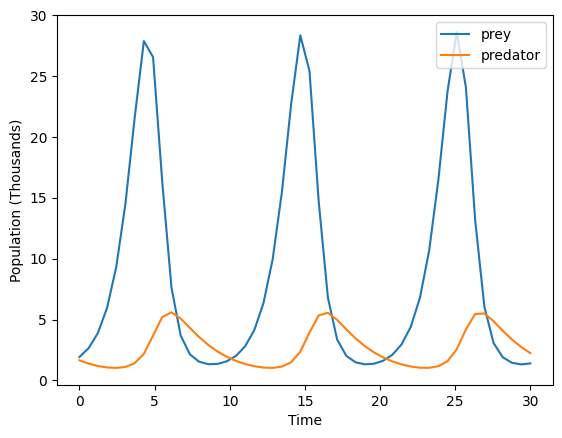

In [10]:
# Set the pyro seed and run the model with the torchdiffeq solver.
set_rng_seed(0)
with torchdiffeq_solver:
    torchdiffeq_trajectory = random_predatorprey_model(as_closure=True)
    plot_trajectory(logging_times, torchdiffeq_trajectory)

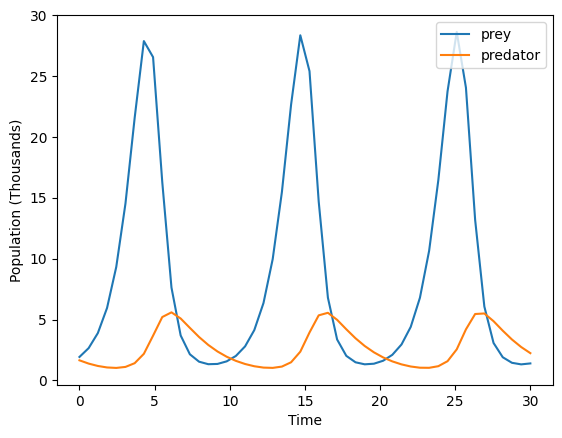

In [11]:
set_rng_seed(0)
with diffeqpy_solver:
    diffeqpy_trajectory = random_predatorprey_model(as_closure=False)
    plot_trajectory(logging_times, diffeqpy_trajectory)

In [12]:
# The two trajectories are the same up to some tolerance.
assert torch.allclose(torchdiffeq_trajectory["prey"], diffeqpy_trajectory["prey"], rtol=1e-2, atol=1e-4)
assert torch.allclose(torchdiffeq_trajectory["predator"], diffeqpy_trajectory["predator"], rtol=1e-2, atol=1e-4)

### Raw Forward Solve Performance Comparison
First, we'll compare the performance of the forward solve, without any interventions or observations.

In [13]:
import time
ITERS = 300

In [14]:
def time_fn(fn, iters):
    times = []
    for i in range(iters):
        print(f"\rProgress {i:04d} / {iters}", end="")
        t_ = time.time()
        fn()
        times.append(time.time() - t_)
    return times

In [15]:
set_rng_seed(0)
with torchdiffeq_solver:
    torchdiffeq_raw_solve_times = time_fn(
        lambda: random_predatorprey_model(as_closure=True),
        ITERS
    )

Progress 0299 / 300

In [16]:
set_rng_seed(0)
with diffeqpy_solver:
    diffeqpy_raw_solve_times = time_fn(
        lambda: random_predatorprey_model(as_closure=False),
        ITERS
    )

Progress 0299 / 300

In [17]:
def plot_times(torchdiffeq_times, diffeqpy_times):
    plt.plot(torchdiffeq_times, label="TorchDiffEq")
    plt.plot(diffeqpy_times, label="DiffEqPy")
    plt.xlabel("Iteration")
    plt.ylabel("Solve Time (s)")
    # Make y axis log scale.
    plt.yscale("log")
    plt.legend()

Text(0.5, 1.0, 'Raw Forward Solve Performance')

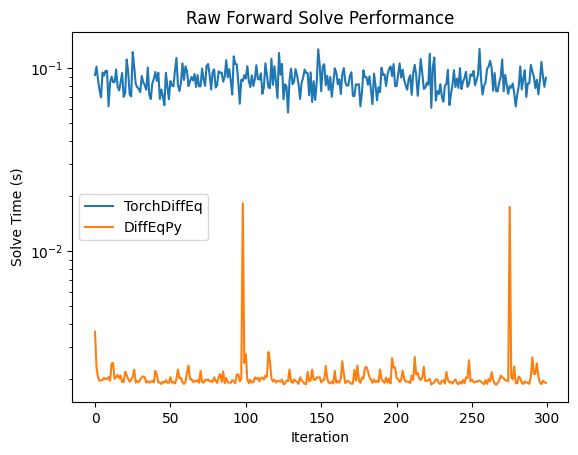

In [18]:
plot_times(torchdiffeq_raw_solve_times, diffeqpy_raw_solve_times)
plt.title("Raw Forward Solve Performance")

### Raw Backward Solve (SVI) Performance Comparison
Now, we'll construct a standard SVI pipeline, and compare the performance of the backward solve of the ELBO. To do so, we'll add some observation noise, condition on the computed trajectories, and compute the gradients of the variational parameters.

In [19]:
POISSON_SCALING = 10
def observation_noise(trajectory):
    return dict(
        prey_obs=sample("prey_obs", Poisson((trajectory["prey"] + 1) * POISSON_SCALING).to_event(1)),
        predator_obs=sample("predator_obs", Poisson((trajectory["predator"] + 1) * POISSON_SCALING).to_event(1))
    )

def descale_observations(trajectory):
    return {k: v / POISSON_SCALING for k, v in trajectory.items()}

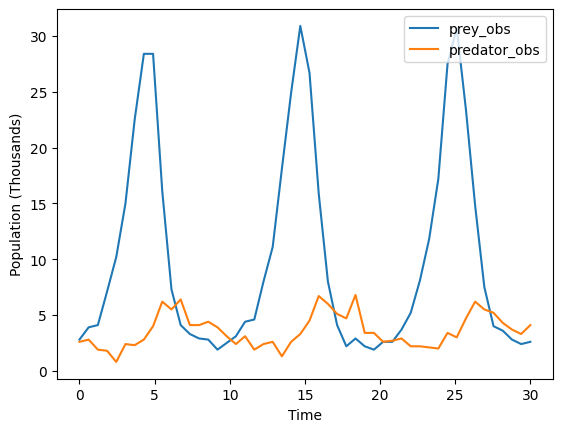

In [20]:
# Plot noisifications of the trajectories computed earlier.
set_rng_seed(0)
observed_data = observation_noise(torchdiffeq_trajectory)
plot_trajectory(logging_times, descale_observations(observed_data))

In [21]:
def returnless_observation_fn(trajectory):
    observation_noise(trajectory)

batch_observation = StaticBatchObservation(times=logging_times, observation=condition(data=observed_data)(returnless_observation_fn))
def build_observed_random_predatorprey_model(*args, **kwargs):
    def model():
        with batch_observation:
            return random_predatorprey_model(*args, log_trajectory=False, **kwargs)
    return model

In [22]:
def build_svi(*args, **kwargs):
    model = build_observed_random_predatorprey_model(*args, **kwargs)
    guide = AutoMultivariateNormal(prior)
    elbo = pyro.infer.Trace_ELBO()(model, guide)
    elbo()  # initialize parameters.
    optim = torch.optim.Adam(elbo.parameters(), lr=1e-2)
    losses = []
    
    def svi_iter():
        optim.zero_grad()
        loss = elbo()
        loss.backward()
        optim.step()
        
        losses.append(loss.detach().item())
    
    return svi_iter, guide, losses

In [23]:
# Now, time the svi loops.
set_rng_seed(0)
with torchdiffeq_solver:
    torchdiffeq_svi_iter, torchdiffeq_guide, torchdiffeq_losses = build_svi(as_closure=True)
    torchdiffeq_svi_times = time_fn(torchdiffeq_svi_iter, ITERS)

Progress 0299 / 300

In [24]:
set_rng_seed(0)
with diffeqpy_solver:
    diffeqpy_svi_iter, diffeqpy_guide, diffeqpy_losses = build_svi(as_closure=False)
    diffeqpy_svi_times = time_fn(diffeqpy_svi_iter, ITERS)

Progress 0299 / 300

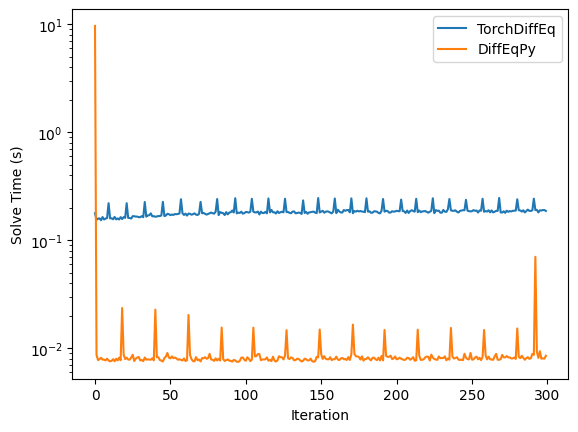

In [25]:
plot_times(torchdiffeq_svi_times, diffeqpy_svi_times)

Text(0.5, 1.0, 'SVI Losses')

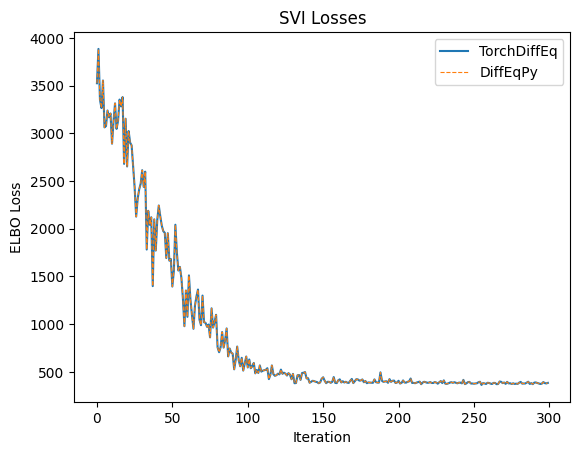

In [26]:
plt.plot(torchdiffeq_losses, label="TorchDiffEq")
plt.plot(diffeqpy_losses, label="DiffEqPy", linestyle="--", linewidth=0.8)
plt.xlabel("Iteration")
plt.ylabel("ELBO Loss")
plt.legend()
plt.title("SVI Losses")

### Forward Multi-World Solve with Dynamic and Static Interventions
We'll introduce 4 prey units at t=10 statically, and introduce 5 predator units the first time the prey population exceeds 20 units. We'll then simulate this forward with a multi-world counterfactual, exploring all 4 combinations of these interventions being applied/not applied.

In [27]:
static_intervention = StaticIntervention(
    time=10.,
    intervention=dict(
        prey=lambda v: v + 4.
    )
)

# Note: the signature for DiffEqPy compatible event functions is as follows, again defined purely wrt the parameters.
# def pure_dynamic_event_fn(t: ArrayLike, state: State[ArrayLike], atemp_params: State[ArrayLike]) -> ArrayLike:
# But we'll use the signature below to support both backends (ignoring the parameters).
# Note that, in order for parameters to be used in a torchdiffeq dynamic event function, they must be included in the state.
def pure_dynamic_event_fn(t: ArrayLike, state: State[ArrayLike], *args, **kwargs) -> ArrayLike:
    ret = state["prey"] - 20.
    return ret

dynamic_intervention = DynamicIntervention(
    event_fn=pure_dynamic_event_fn,
    intervention=dict(
        predator=lambda v: v + 5.
    )
)

In [28]:
def multiworld_forward(*args, **kwargs):
    with static_intervention:
        with dynamic_intervention:
            with MultiWorldCounterfactual() as cf:
                traj = random_predatorprey_model(*args, **kwargs)
                return traj, cf

In [29]:
# Make logging_times higher resolution to better visualize the interventions.
logging_times = torch.linspace(start_time, end_time, 500)

In [30]:
set_rng_seed(0)
with torchdiffeq_solver:
    # It turns out that this example breaks torchdiffeq sometimes. FIXME
    def erroring_multiworld_forward(*args, **kwargs):
        try:
            return multiworld_forward(*args, **kwargs)
        except RuntimeError as e:
            print(f"\nFAILED: {e}")
            return None
            
    torchdiffeq_multiworld_times = time_fn(
        lambda: erroring_multiworld_forward(as_closure=True),
        ITERS
    )

Progress 0009 / 300
FAILED: The event function returned an unexpected number of events.
Progress 0037 / 300
FAILED: The event function returned an unexpected number of events.
Progress 0128 / 300
FAILED: The event function returned an unexpected number of events.
Progress 0269 / 300
FAILED: The event function returned an unexpected number of events.
Progress 0299 / 300

In [31]:
set_rng_seed(0)
with diffeqpy_solver:
    diffeqpy_multiworld_times = time_fn(
        lambda: multiworld_forward(as_closure=False),
        ITERS
    )

Progress 0299 / 300

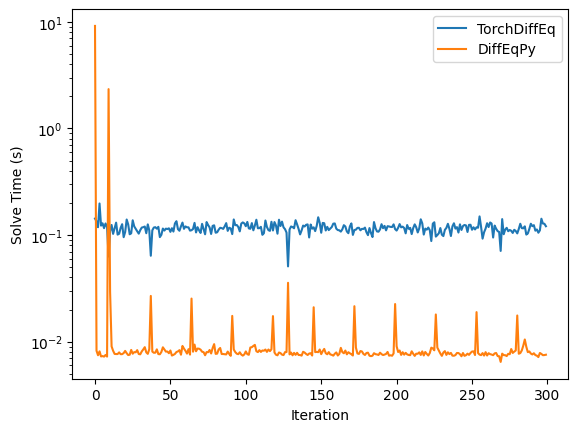

In [32]:
plot_times(torchdiffeq_multiworld_times, diffeqpy_multiworld_times)

### Visualizing Multiple Worlds

In [33]:
from chirho.indexed.ops import gather, IndexSet

In [34]:
set_rng_seed(0)
with diffeqpy_solver:
    diffeqpy_multiworld_traj, diffeqpy_multiworld = multiworld_forward(as_closure=False)

In [35]:
# TODO figure out what names to use for the split trajectory indices.

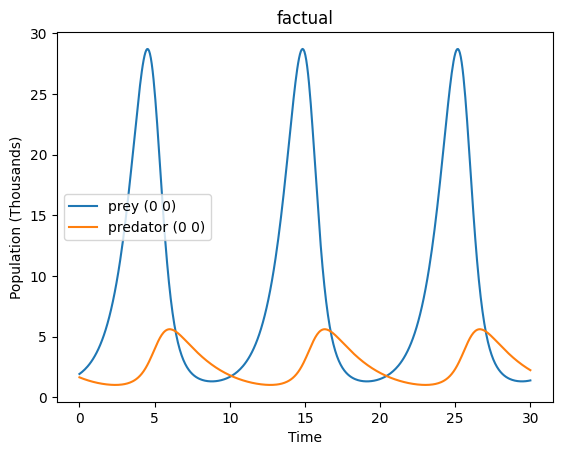

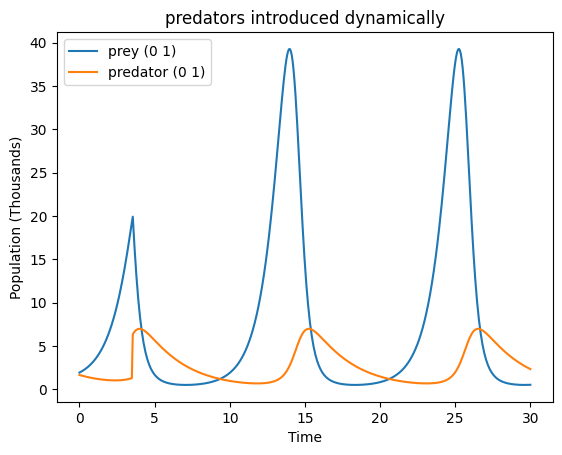

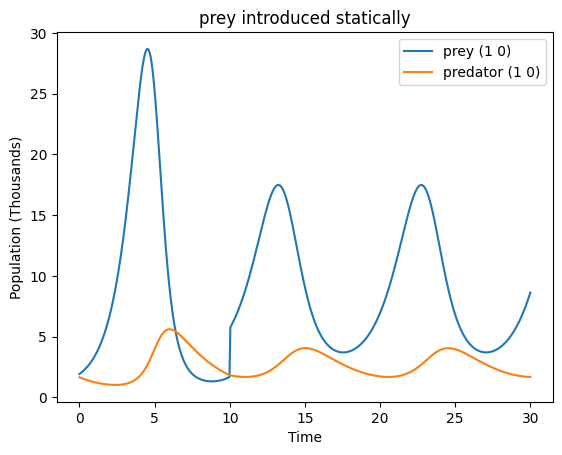

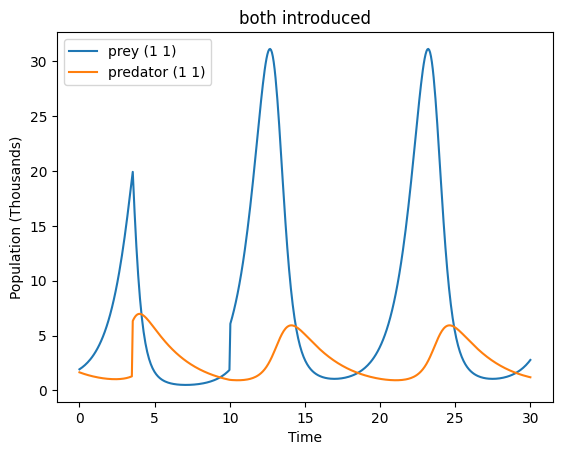

In [36]:
from itertools import product
world_names = [
    "factual",
    "predators introduced dynamically",
    "prey introduced statically",
    "both introduced"
]
for (i, j), world_name in zip(product(range(2), range(2)), world_names):
    plt.figure()
    for k in diffeqpy_multiworld_traj.keys():
        plt.plot(logging_times, diffeqpy_multiworld_traj[k][i, j].squeeze(), label=f"{k} ({i} {j})")
    plt.xlabel("Time")
    plt.ylabel("Population (Thousands)")
    plt.title(world_name)
    plt.legend()